# Signal Fitting
We now have a successful background model in the form of a second-order polynomial. We now wish to fit an analytical function to our signal. In this way we can then assess how some figures of merit change based on different cuts or cutting methods since we have a way to estimate both signal and background within the same region.

## Environment Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
from utilities import Data, Consts

In [3]:
s = Data(*Consts().get_simulated_tuple())

In [4]:
df = s.fetch_features(['Lb_M', 'Lb_BKGCAT'])
df['cat'] = np.where(df['Lb_BKGCAT'].isin([10, 50]), 1, 0)
df.drop('Lb_BKGCAT', axis=1, inplace=True)
g = df.groupby('cat')

## Initial Analysis

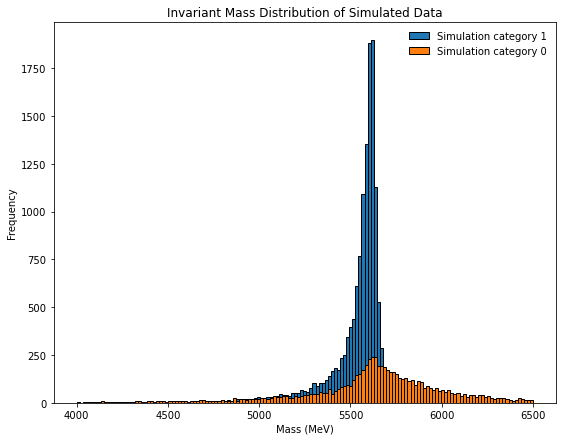

In [5]:
def hist(data, bins, savefig=None):
    fig, ax = plt.subplots(1, 1, figsize=(9, 7))
    cats = [1, 0]
    for i, data in enumerate(list(data)):
        ax.hist(data, bins=bins, edgecolor='k', label=f'Simulation category {cats[i]}')
    ax.set_xlabel('Mass (MeV)')
    ax.set_ylabel('Frequency')
    plt.legend(frameon=False)
    plt.title('Invariant Mass Distribution of Simulated Data')
    if savefig is not None:
        plt.savefig(f'/home/user211/project/images/signalfits/{savefig}.png', dpi=800)
    plt.show()
    
bins = np.linspace(4000, 6500, 150)
hist([g.get_group(1)['Lb_M'], g.get_group(0)['Lb_M']], bins)

Compute the errors assuming Poission statistics within each bin that is $\sigma\propto\sqrt{N}$

In [6]:
low_mass_limit, high_mass_limit = 3500, 7000
no_bins = 150

bins = np.linspace(low_mass_limit, high_mass_limit, no_bins + 1)
bin_centres = [np.mean(bins[i:i+2]) for i in range(len(bins)-1)]
bin_width = bins[1]- bins[0]

df = df[df['Lb_M'].between(low_mass_limit, high_mass_limit)]
g = df.groupby('cat')

f1, _ = np.histogram(g.get_group(1)['Lb_M'], bins=bins)
f2, _ = np.histogram(g.get_group(0)['Lb_M'], bins=bins)
err1, err2 = np.sqrt(f1), np.sqrt(f2)

d1 = np.array([bin_centres, f1, err1]).T
d2 = np.array([bin_centres, f2, err2]).T
d3 = np.array([bin_centres, f1+f2, np.sqrt(f1+f2)]).T

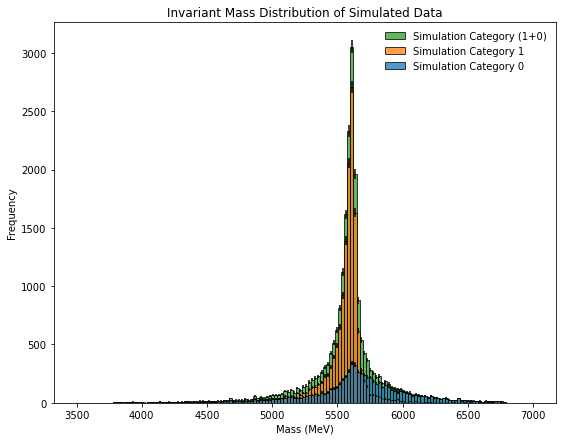

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

ax.bar(d3[:,0], d3[:,1], width=bin_width, yerr=d3[:,2], label='Simulation Category (1+0)', edgecolor='k', color='#2ca02c', alpha=0.75)
ax.bar(d1[:,0], d1[:,1], width=bin_width, yerr=d1[:,2], label='Simulation Category 1', edgecolor='k', color='#ff7f0e', alpha=0.75)
ax.bar(d2[:,0], d2[:,1], width=bin_width, yerr=d2[:,2], label='Simulation Category 0', edgecolor='k', color='#1f77b4', alpha=0.75)

ax.set_xlabel('Mass (MeV)')
ax.set_ylabel('Frequency')
plt.legend(frameon=False)
plt.title('Invariant Mass Distribution of Simulated Data')
#plt.savefig('/home/user211/project/images/signalfits/starting_distribution.png', dpi=800)
plt.show()

In [8]:
import SignalFunctions as sf
from scipy.optimize import curve_fit

d1 = d1[(d1[:,1] != 0)]
x, y, yerr = d1[:,0], d1[:,1], d1[:,2]
# Curve fit can take errors which then performs a standard chi-square minimisation

popt1, pcov1 = curve_fit(sf.gaussian, x, y, [100, 5500, 100], yerr, absolute_sigma=True)

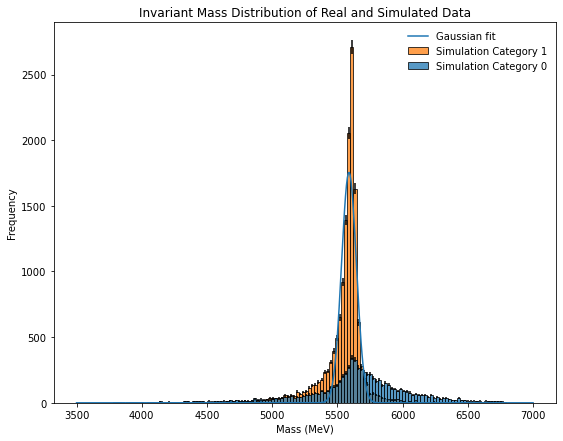

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
func_x = np.linspace(low_mass_limit, high_mass_limit, 500)
ax.bar(d1[:,0], d1[:,1], width=bin_width, yerr=d1[:,2], label='Simulation Category 1', edgecolor='k', color='#ff7f0e', alpha=0.75)
ax.bar(d2[:,0], d2[:,1], width=bin_width, yerr=d2[:,2], label='Simulation Category 0', edgecolor='k', color='#1f77b4', alpha=0.75)
ax.plot(func_x, sf.gaussian(func_x, *popt1), label='Gaussian fit')

ax.set_xlabel('Mass (MeV)')
ax.set_ylabel('Frequency')
plt.legend(frameon=False)
plt.title('Invariant Mass Distribution of Real and Simulated Data')
#plt.savefig('/home/user211/project/images/signalfits/GaussianFit.png', dpi=800)
plt.show()

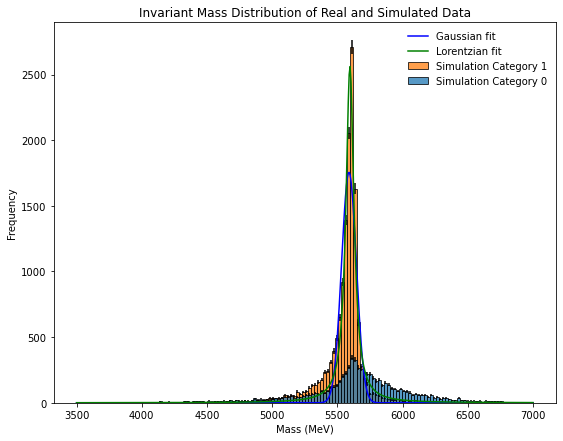

In [10]:
popt2, pcov2 = curve_fit(sf.scaled_lorentzian, x, y, [800000, 5500, 190], yerr, absolute_sigma=True)
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
func_x = np.linspace(low_mass_limit, high_mass_limit, 500)
ax.bar(d1[:,0], d1[:,1], width=bin_width, yerr=d1[:,2], label='Simulation Category 1', edgecolor='k', color='#ff7f0e', alpha=0.75)
ax.bar(d2[:,0], d2[:,1], width=bin_width, yerr=d2[:,2], label='Simulation Category 0', edgecolor='k', color='#1f77b4', alpha=0.75)
ax.plot(func_x, sf.gaussian(func_x, *popt1), label='Gaussian fit', color='blue')
ax.plot(func_x, sf.scaled_lorentzian(func_x, *popt2), label='Lorentzian fit', color='green')
ax.set_xlabel('Mass (MeV)')
ax.set_ylabel('Frequency')
plt.legend(frameon=False)
plt.title('Invariant Mass Distribution of Real and Simulated Data')
#plt.savefig('/home/user211/project/images/signalfits/LorentzianAndGaussian.png', dpi=800)
plt.show()

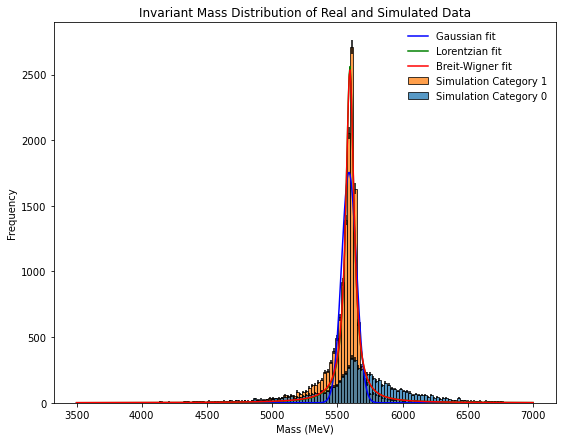

In [11]:
popt3, pcov3 = curve_fit(sf.breit_wigner, x, y, [5500, 100, 0.3E+10], yerr, absolute_sigma=True)

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
func_x = np.linspace(low_mass_limit, high_mass_limit, 500)
ax.bar(d1[:,0], d1[:,1], width=bin_width, yerr=d1[:,2], label='Simulation Category 1', edgecolor='k', color='#ff7f0e', alpha=0.75)
ax.bar(d2[:,0], d2[:,1], width=bin_width, yerr=d2[:,2], label='Simulation Category 0', edgecolor='k', color='#1f77b4', alpha=0.75)
ax.plot(func_x, sf.gaussian(func_x, *popt1), label='Gaussian fit', color='blue')
ax.plot(func_x, sf.scaled_lorentzian(func_x, *popt2), label='Lorentzian fit', color='green')
ax.plot(func_x, sf.breit_wigner(func_x, *popt3), label='Breit-Wigner fit', color='red')

ax.set_xlabel('Mass (MeV)')
ax.set_ylabel('Frequency')
plt.legend(frameon=False)
plt.title('Invariant Mass Distribution of Real and Simulated Data')
#plt.savefig('/home/user211/project/images/signalfits/LorentzianGaussianBreitwigner.png', dpi=800)
plt.show()

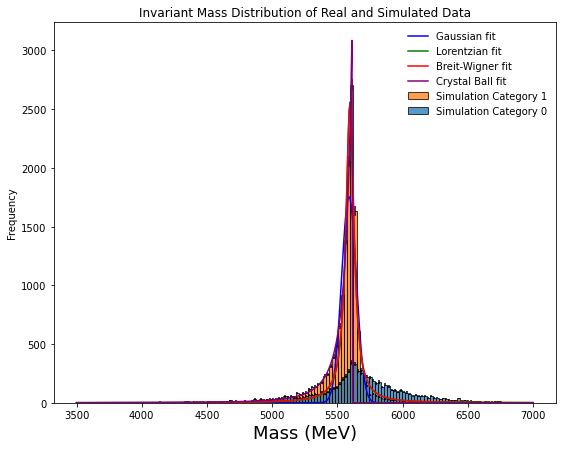

In [12]:
popt4, pcov4 = curve_fit(sf.cball, x, y, [0.7E+5, 0.1, 2, 5500], yerr, absolute_sigma=True)

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
func_x = np.linspace(low_mass_limit, high_mass_limit, 500)
ax.bar(d1[:,0], d1[:,1], width=bin_width, yerr=d1[:,2], label='Simulation Category 1', edgecolor='k', color='#ff7f0e', alpha=0.75)
ax.bar(d2[:,0], d2[:,1], width=bin_width, yerr=d2[:,2], label='Simulation Category 0', edgecolor='k', color='#1f77b4', alpha=0.75)
ax.plot(func_x, sf.gaussian(func_x, *popt1), label='Gaussian fit', color='blue')
ax.plot(func_x, sf.scaled_lorentzian(func_x, *popt2), label='Lorentzian fit', color='green')
ax.plot(func_x, sf.breit_wigner(func_x, *popt3), label='Breit-Wigner fit', color='red')
ax.plot(func_x, sf.cball(func_x, *popt4), label='Crystal Ball fit', color='purple')

ax.set_xlabel('Mass (MeV)', fontsize=18)
ax.set_ylabel('Frequency')
plt.legend(frameon=False)
plt.title('Invariant Mass Distribution of Real and Simulated Data')
#plt.savefig('/home/user211/project/images/signalfits/AllAndCrystalBall.png', dpi=800)
plt.show()

In [13]:
def double_crystal_ball(x, A, mu, s, a_l, a_R, n_l, n_h):
    t = (x-mu)/s
    low = np.where(t <= a_l)[0]
    mid = np.where(np.logical_and(t > a_l, t < a_R))[0]
    high = np.where(t >= a_R)[0]
    a_l, a_R = np.abs(a_l), np.abs(a_R)
    l = ((n_l/a_l)**n_l)*np.exp(-0.5*(a_l**2))*(((n_l/a_l) - a_l - t[low])**(-n_l))
    m = np.exp(-0.5*(t[mid]**2))
    h = ((n_h/a_R)**n_h)*np.exp(-0.5*(a_R**2))*(((n_h/a_R) - a_R - t[high])**(-n_h))
    return A*np.concatenate((l, m ,h))

In [14]:
def model(x, A, mu, s, a_l, a_R, n_l, n_h):
    t = (x-mu)/s
    low = np.where(t <= a_l)[0]
    mid = np.where(np.logical_and(t > a_l, t < a_R))[0]
    high = np.where(t >= a_R)[0]
    a_l, a_R = np.abs(a_l), np.abs(a_R)
    l = ((n_l/a_l)**n_l)*np.exp(-0.5*(a_l**2))*(((n_l/a_l) - a_l - t[low])**(-n_l))
    m = np.exp(-0.5*(t[mid]**2))
    h = ((n_h/a_R)**n_h)*np.exp(-0.5*(a_R**2))*(((n_h/a_R) - a_R - t[high])**(-n_h))
    return A*np.concatenate((l, m ,h))

def likelihood(frequencies, A, mu, s, a_l, a_R, n_l, n_h):
    """
    This is quite a slow and expensive way to compute the likelihood
    """
    model_params = [A, mu, s, a_l, a_R, n_l, n_h]
    points = [np.exp(-model(f, *model_params)) * (model(f, *model_params)**f)/(np.math.factorial(f)) for f in frequencies]
    return np.prod(points)

def log_likelihood(A, mu, s, a_l, a_R, n_l, n_h, freqs=d1[:,1], d=d1[:,0]):
    """
    An fast implementation of likelihood
    """
    params = [A, mu, s, a_l, a_R, n_l, n_h]
    return np.sum([-model(d, *params) + (f*np.log(model(d, *params).astype(float))) - np.log(np.math.factorial(f)) for f in freqs])

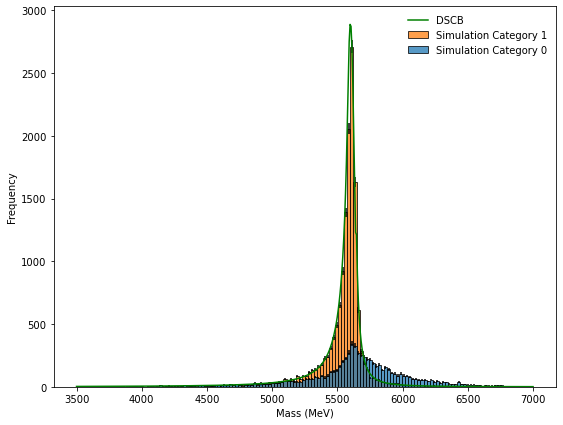

In [15]:

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(d1[:,0], d1[:,1], width=bin_width, yerr=d1[:,2], label='Simulation Category 1', edgecolor='k', color='#ff7f0e', alpha=0.75)
ax.bar(d2[:,0], d2[:,1], width=bin_width, yerr=d2[:,2], label='Simulation Category 0', edgecolor='k', color='#1f77b4', alpha=0.75)
ax.plot(func_x, double_crystal_ball(func_x, *[2900, 5600, 30, -0.75, 1.36, 2, 2]), label='DSCB', color='green')
ax.set_ylabel('Frequency')
ax.set_xlabel('Mass (MeV)')
plt.legend(frameon=False)
plt.savefig('/home/user211/project/images/signalfits/DSCB2.png', dpi=800)
plt.show()

In [16]:
# My own special minimising function
param_ranges = {
    'N': np.linspace(2700, 3100, 100), 
    'mu': np.linspace(5500, 5700, 500), 
    's': np.linspace(25, 35, 100), 
    'a_low': np.linspace(-1, -0.5, 50), 
    'a_high': np.linspace(1.1, 1.4, 30), 
    'n_low': np.linspace(2, 5, 10), 
    'n_high': np.linspace(2, 5, 10)
    }

fixed_params = ['N', 'mu', 's', 'a_low', 'a_high', 'n_low', 'n_high']
mean_values = [np.mean(param_ranges[i]) for i in fixed_params]
best_params = {
    'N': 2900, 
    'mu': 5600, 
    's': 30, 
    'a_low': -0.75, 
    'a_high': 1.25, 
    'n_low': 3.5, 
    'n_high': 3.5
}

def chi_square_dof(model, params, data, significane=0.05):
    """
    Calculate the chi-squared per degree of freedom for some data and a model
    """
    from scipy.stats import chi2
    df = len(data[:,0]) - len(params)
    test_value = chi2.ppf(1-significane, df)/df
    chi_square = np.nansum(((data[:,1]-model(data[:,0], *params))/data[:,2])**2)
    df_new = df - np.count_nonzero(np.isnan(model(data[:,0], *params))) 
    chi_squared_dof = chi_square/df_new
    return chi_squared_dof, chi_squared_dof < test_value

for n, param in enumerate(fixed_params):
    # Param is the one that will be varied whilst others are constant
    this_params = [np.mean(param_ranges[j]) for j in fixed_params if j != param]
    this_params.insert(n, np.mean(param_ranges[param]))
    temp_params = this_params
    chi_square_initial = chi_square_dof(double_crystal_ball, this_params, d1)[0]
    #print(chi_square_initial)
    for param_value in param_ranges[param]:
        temp_params[n] = param_value
        temp = chi_square_dof(double_crystal_ball, temp_params, d1)[0]
        if np.abs(temp-1) < np.abs(chi_square_initial-1):
            chi_square_initial = temp
            # Save this value for this parameter to a fixed one now in dictionary
            best_params[param] = param_value
            # We want the next iteration to also use this new optimised value
            param_ranges[param] = param_value
    print(f'Parameter: {param}, Best Chi-Square Possible: {chi_square_initial}')
        
best_params

/tmp/ipykernel_1954183/2928757600.py:9: RuntimeWarning: invalid value encountered in power
  h = ((n_h/a_R)**n_h)*np.exp(-0.5*(a_R**2))*(((n_h/a_R) - a_R - t[high])**(-n_h))


Parameter: N, Best Chi-Square Possible: 17.488723131487685
Parameter: mu, Best Chi-Square Possible: 16.542127935198483
Parameter: s, Best Chi-Square Possible: 11.836566229735846
Parameter: a_low, Best Chi-Square Possible: 9.706746990427527
Parameter: a_high, Best Chi-Square Possible: 9.706746990427527
Parameter: n_low, Best Chi-Square Possible: 8.364507896637512
Parameter: n_high, Best Chi-Square Possible: 8.364507896637512


{'N': 2825.252525252525,
 'mu': 5603.807615230461,
 's': 35.0,
 'a_low': -0.6632653061224489,
 'a_high': 1.25,
 'n_low': 3.0,
 'n_high': 3.5}

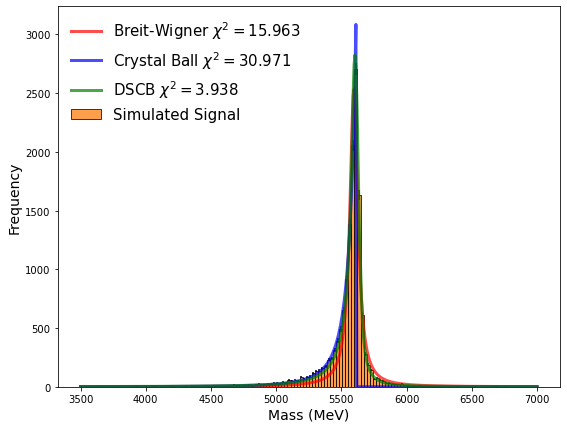

3.9380090190683434

In [60]:

#chi1 = chi_square_dof(sf.breit_wigner, popt3, d1)[0]
#chi2 = chi_square_dof(sf.cball, popt4, d1)[0]
chi3 = chi_square_dof(double_crystal_ball, [2825.252525252525, 5603.807615230461, 27.52, -0.73, 1.38, 2.17, 2.00], d1)[0]


fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(d1[:,0], d1[:,1], width=bin_width, yerr=d1[:,2], label='Simulated Signal', edgecolor='k', color='#ff7f0e', alpha=0.75)
ax.plot(func_x, sf.breit_wigner(func_x, *popt3), label=rf'Breit-Wigner $\chi^2=${chi1:.3f}', color='red',alpha=0.7, linewidth=3)
ax.plot(func_x, sf.cball(func_x, *popt4), label=rf'Crystal Ball $\chi^2=${chi2:.3f}', color='blue', alpha=0.7, linewidth=3)
ax.plot(func_x, double_crystal_ball(func_x,*[2825.252525252525, 5603.807615230461, 27.52, -0.73, 1.38, 2.17, 2.00]), label=rf'DSCB $\chi^2=${chi3:.3f}', color='green', alpha=0.7, linewidth=3)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xlabel('Mass (MeV)', fontsize=14)
plt.legend(frameon=False, prop={'size': 15})
plt.savefig('/home/user211/project/images/signalfits/DCSB_CB_BW.png', dpi=800)
plt.show()



chi3

# 6.524273626911914
# 5.3583980846330705
# 4.738838290691814
# 4.627558424567317
